In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# import swifter
import gc
import timeit
# from numba import jit, cuda
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix,roc_auc_score,roc_curve,confusion_matrix
from sklearn import metrics
from scipy import sparse
import seaborn as sn
from joblib import dump, load
import multiprocessing as mp
import time
%matplotlib inline
import pickle
from tqdm.auto import tqdm

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
tqdm.pandas()
import plotly as pty
from ipywidgets import IntProgress

from IPython import display

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
gc.enable()
# gc.disable()

## Methods used in the pipeline

In [3]:
def select_features(X,y,nb,indices):
#     X_selected = X[feat_importances_columns]
    X_selected=X.iloc[:,indices[:nb]]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=42, stratify=y)
    return X_train, X_test,y_train, y_test
def searchBestNumber(xmin, xmax, step, X, y, indices):

        # lists to store values of performance measures. used to plot later
    acc=[]
    pre=[]
    rec=[]
    auc=[]
    f=[]
    # x is used to store the iteration number
    x=[]

    for i in range(xmin,xmax,step):
        fig, ax = plt.subplots(figsize=(22,9))

        X_train, X_test, y_train, y_test = select_features(X,y,i,indices)
        classifier = RandomForestClassifier(random_state=10,verbose=0,n_jobs=-1)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_prob = classifier.predict_proba(X_test)[:, 1]
        accuracy, precision, recall, f1, aucs= get_metrics(y_test, y_pred,y_prob)
        print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % 
              (accuracy, precision, recall, f1,aucs))
        print("-----------------------------------------------------------------------\n")

        x.append(i)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
        f.append(f1)
        auc.append(aucs)

    #     plt.xticks(x)
    #     plt.yticks(y)

        prep = plt.plot(x,pre, label="Precision", marker='o', color='orange')
        f1p = plt.plot(x,f,label="F1-score", marker='o', color='r')
        accp = plt.plot(x,acc, label="Accuracy", marker='o',color='b') 
        recp = plt.plot(x,rec,label="Recall", marker='o', color='g')
        aucp = plt.plot(x,auc,label="AUC score", marker='o', color='black')



    #     plt.legend([accp, prep,recp,f1p])#, ['Acuuracy', 'Precision', 'Recall', 'F1-score'])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.xlabel("Number of Features")
        plt.title("Performance versus Nb of Features")
        display.clear_output(wait=True) #Uncomment to clear output each iteration 
        plt.show()

    #Get the index of best performances    
    print("Highest Accuracy: ",max(acc))
    # calculate index of the highest accuracy, precision, recall, f1 and auc score, 
    # values depending on the size of step defined above
    bestNumber = acc.index(max(acc))*step+xmin
    print("Index of highest Accuracy  ",bestNumber)

    print("Highest Precision: ",max(pre))
    bestNumber = pre.index(max(pre))*step+xmin
    print("Nb of features  of highest Precision ",bestNumber)

    print("Highest Recall: ",max(rec))
    bestNumber = rec.index(max(rec))*step+xmin
    print("Nb of features  of highest Recall    ",bestNumber)

    print("Highest F1: ",max(f))
    bestNumber = f.index(max(f))*step+xmin
    print("Nb of features  of highest F1        ",bestNumber)

    print("Highest AUC score: ",max(auc))
    bestNumber = auc.index(max(auc))*step+xmin
    print("Nb of features of highest AUC score ",bestNumber)
    
    return bestNumber



        
def get_metrics(y_test, y_predicted, y_prob):
            accuracy = accuracy_score(y_test, y_predicted)
            precision = precision_score(y_test, y_predicted, average='weighted')
            recall = recall_score(y_test, y_predicted, average='weighted')
            f1 = f1_score(y_test, y_predicted, average='weighted')
            auc= roc_auc_score(y_test, y_prob)
            return accuracy, precision, recall, f1, auc
        
def benchmarkAlgos(X, y):
    # ind is the index of the number of features with highest performance

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


    classifiers = {
        'RandomForestClassifier': RandomForestClassifier(random_state=10,verbose=0,n_jobs=-1),
        'LogisticRegression': LogisticRegression(verbose=0,n_jobs=-1),
        'SGDClassifier': SGDClassifier(average=100,verbose=0, n_jobs=-1),
    }
    for name, classifier in classifiers.items():
        start = time.time()
        classifier.fit(X_train, y_train)
        end = time.time()

        plot_roc_curve(classifier,X_test,y_test, pos_label='0')

        # total time taken
        print(f"Runtime of ",name, f" training is {end - start} secs")


        y_pred = classifier.predict(X_test)
        print("Perf Results for ", name, " : \n -------------------------------------")

    #   SGDclassifier does not have predict_proba  method
        if (name!='SGDClassifier'):
            y_prob = classifier.predict_proba(X_test)[:, 1]

        accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
        print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
        print("-----------------------------------------------------------------------\n")

def embeddedSelect(X,y):
    clf = RandomForestClassifier(random_state=10,verbose=1, n_jobs=-1).fit(X,y)

    # print("score {:.3f}".format(score))
    # rank the features
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]#[::-1] is to reverse the array

    n_features = X.shape[1]
    # get the features sorted by decreasing importance
    feat_importances_sorted = [(indices[f], importances[indices[f]]) for f in range(n_features)]
    print("number of features:  ", len(X.columns))
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 16}

    matplotlib.rc('font', **font)
    figure, axes = plt.subplots(1, 2,figsize=(22,12))
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    feat_importances.nlargest(30).plot(ax=axes[0],kind='pie', normalize=True, title='Features importances')
    feat_importances.nlargest(50).plot(ax=axes[1],kind='barh', title='  Features importances')
    return indices



# Step 0 Import Labels

In [4]:
y = []
def importLabels():
#     with open('./Data/shortlabels.txt', 'r') as filehandle:
    with open('D:/DataSet/Data/labels.txt', 'r') as filehandle:


        for line in filehandle:
            # remove linebreak, if exists, which is the last character of the string
            if(line[-1] == "\n"):
                currentPlace = line[:-1]
            else:
                currentPlace = line[:]
            # add item to the list
            y.append(currentPlace)
importLabels()


# Step 1: Read df from disk, Precise the size of k
## Load BoW k=7 dataset from disk

### Optional: TfIdf transformation

In [7]:
# from sklearn.feature_extraction.text import TfidfTransformer
# cols=X.columns
# transformer = TfidfTransformer()
# training_tfidf = transformer.fit_transform(X).toarray()
# X = pd.DataFrame(training_tfidf, columns=cols)


In [8]:
# X = pd.DataFrame(training_tfidf.toarray(), columns=kmers)
# X

In [9]:


# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y) # If using tf-idf vector, just replace X_cv with X1.


##  1.1 Using Embedded:   Plot most important features 
## then  Search and select the best Number of features in order of importance

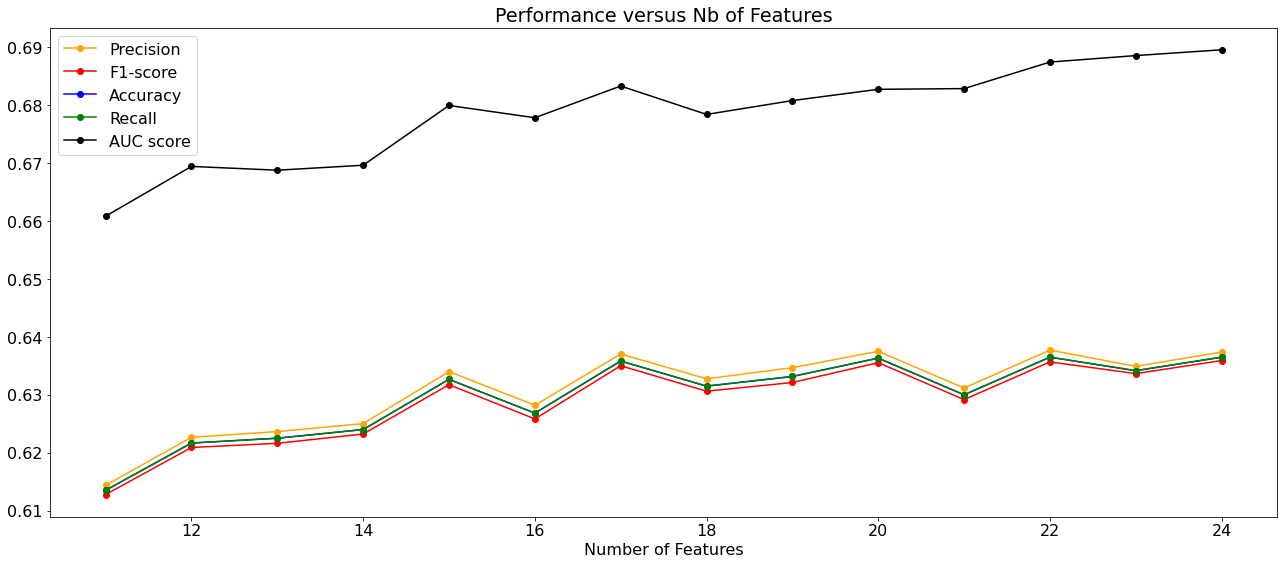

Highest Accuracy:  0.6365
Index of highest Accuracy   22
Highest Precision:  0.6377255894145132
Nb of features  of highest Precision  22
Highest Recall:  0.6365
Nb of features  of highest Recall     22
Highest F1:  0.6359125955405999
Nb of features  of highest F1         24
Highest AUC score:  0.6895992222222223
Nb of features of highest AUC score  24


In [32]:

for k in [6,7]:
    X = pd.read_feather(r"D:\DataSet\TfIdf\dfk"+str(k)+".feather")

    indices = embeddedSelect(X,y)
    # min nb of feat to start the search from
    xmin=11
    # max nb of feat to stop the search at
    xmax=25
    # loop over the a range of number of features up until xmax with a step to increase speed
    step = 1
    #ind = 
    bestNumber1 = searchBestNumber(xmin, xmax, step, X, y, indices)
    #########################################################
    # write to disk dataframe with best number of freatures
    #########################################################

#     X.iloc[:, indices[:bestNumber1]].to_feather(r"D:\DataSet\TfIdf\D1-best-"+str(bestNumber1)+"-"+str(k)+".feather")


#         print("nb features: " + str(i)+"\n")
#         print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


## 1.2 (optional) Checkpoint: Read from disk best features df k=6, k=7

In [34]:

X_selected6 = pd.read_feather(r"D:\DataSet\TfIdf\D1-best-24-6.feather")
X_selected7 = pd.read_feather(r"D:\DataSet\TfIdf\D1-best-24-7.feather")


## 1.3 Get performance for three algos on best number of features

Runtime of  RandomForestClassifier  training is 3.322504997253418 secs
Perf Results for  RandomForestClassifier  : 
 -------------------------------------
accuracy = 0.636 
precision = 0.637 
recall = 0.636 
f1 = 0.636 
AUC score = 0.690
-----------------------------------------------------------------------

Runtime of  LogisticRegression  training is 3.628945827484131 secs
Perf Results for  LogisticRegression  : 
 -------------------------------------
accuracy = 0.618 
precision = 0.619 
recall = 0.618 
f1 = 0.618 
AUC score = 0.671
-----------------------------------------------------------------------

Runtime of  SGDClassifier  training is 1.3569772243499756 secs
Perf Results for  SGDClassifier  : 
 -------------------------------------
accuracy = 0.621 
precision = 0.621 
recall = 0.621 
f1 = 0.621 
AUC score = 0.671
-----------------------------------------------------------------------



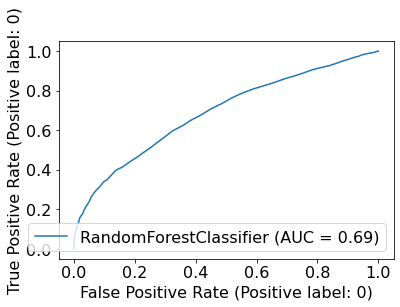

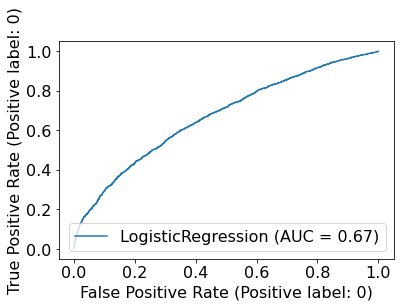

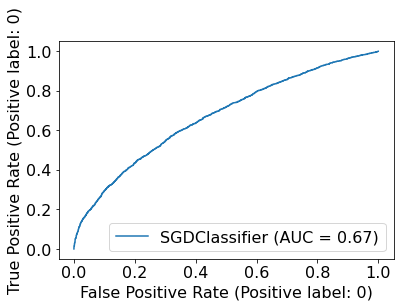

In [35]:
# bestNumber1 is the index of the number of features with highest performance k6
benchmarkAlgos(X_selected6, y)

Runtime of  RandomForestClassifier  training is 1.9590094089508057 secs
Perf Results for  RandomForestClassifier  : 
 -------------------------------------
accuracy = 0.892 
precision = 0.910 
recall = 0.892 
f1 = 0.890 
AUC score = 0.918
-----------------------------------------------------------------------

Runtime of  LogisticRegression  training is 2.0210845470428467 secs
Perf Results for  LogisticRegression  : 
 -------------------------------------
accuracy = 0.723 
precision = 0.723 
recall = 0.723 
f1 = 0.723 
AUC score = 0.813
-----------------------------------------------------------------------

Runtime of  SGDClassifier  training is 0.48877668380737305 secs
Perf Results for  SGDClassifier  : 
 -------------------------------------
accuracy = 0.730 
precision = 0.730 
recall = 0.730 
f1 = 0.730 
AUC score = 0.813
-----------------------------------------------------------------------



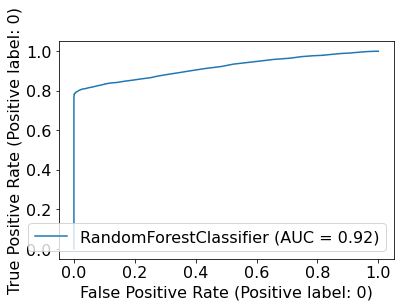

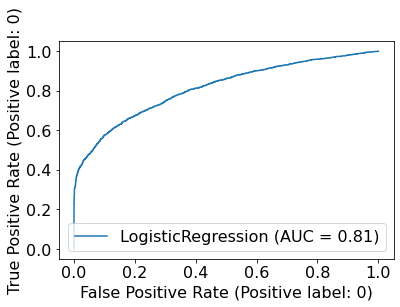

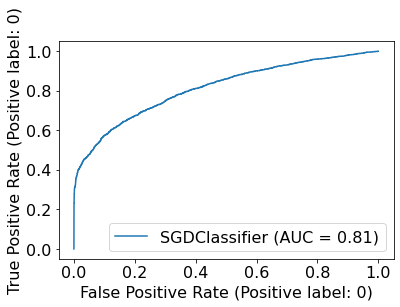

In [36]:
# bestNumber1 is the index of the number of features with highest performance k7
benchmarkAlgos(X_selected7, y)

## Step 2.1 Concatenate k6 and k7 

In [37]:
X = pd.concat((X_selected6, X_selected7), axis=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


<AxesSubplot:title={'center':'K=6,7 Features importances'}>

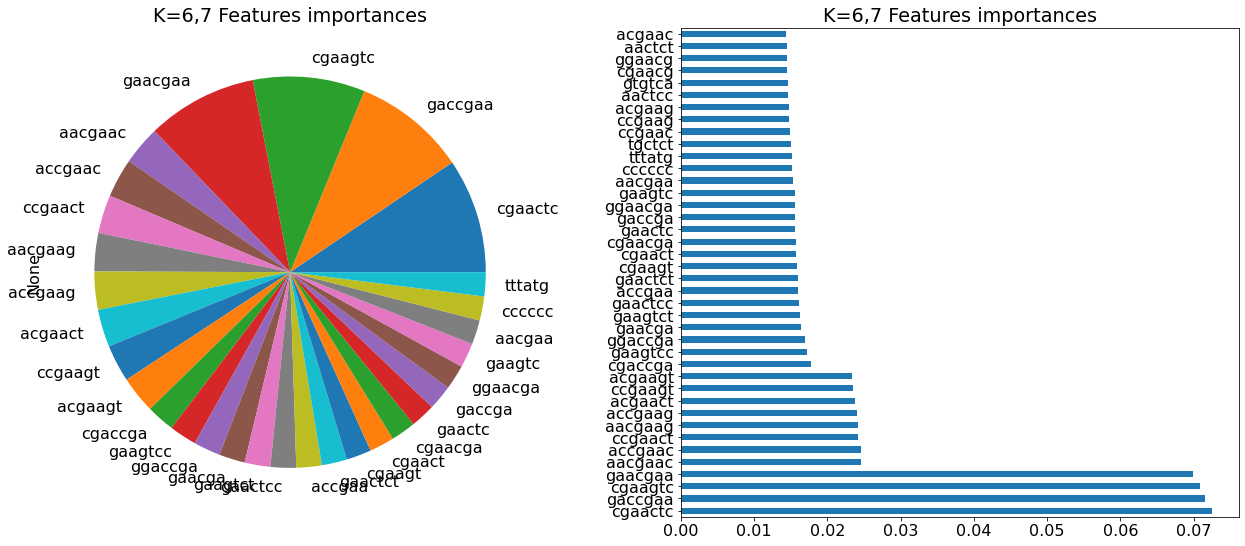

In [41]:
clf = RandomForestClassifier(random_state=10,verbose=1, n_jobs=-1).fit(X,y)

# rank the features
importances = clf.feature_importances_
indices1 = np.argsort(importances)[::-1]#[::-1] is to reverse the array

n_features = X.shape[1]
# get the features sorted by decreasing importance
feat_importances_sorted = [(indices[f], importances[indices[f]]) for f in range(n_features)]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
figure, axes = plt.subplots(1, 2,figsize=(22,9))
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
feat_importances.nlargest(30).plot(ax=axes[0],kind='pie', normalize=True, title='K=6,7 Features importances')
feat_importances.nlargest(40).plot(ax=axes[1],kind='barh', title='K=6,7 Features importances')

## Step 2.2 Search incrementally the best number of features out of most important given before 

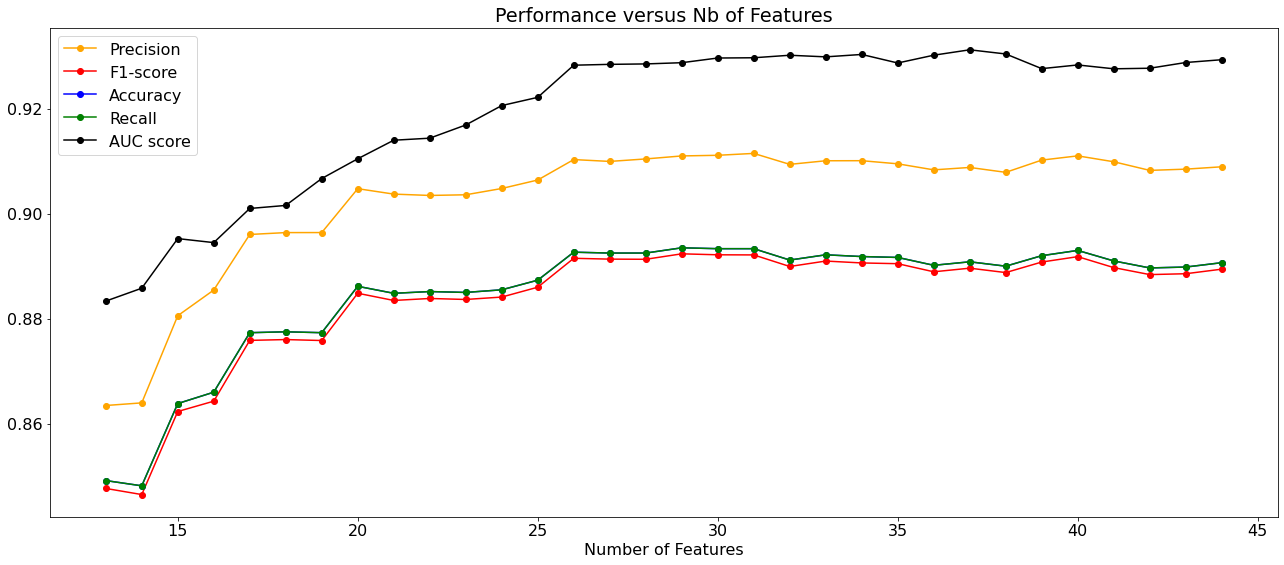

Highest Accuracy:  0.8935
Index of highest Accuracy   29
Highest Precision:  0.9114795829410329
Nb of features  of highest Precision  31
Highest Recall:  0.8935
Nb of features  of highest Recall     29
Highest F1:  0.8923542878131325
Nb of features  of highest F1         29
Highest AUC score:  0.9312133333333333
Nb of features of highest AUC score  37


In [45]:
##################################################################################################################
# 
# Input: features from previous step, ordered according to importance
# Output: -ind: best performing number of features, 
##################################################################################################################
# min nb of feat to start the search from
xmin=13
# max nb of feat to stop the search at
xmax=45
# loop over the a range of number of features up until xmax with a step to increase speed
step = 1
featBestNumber1 = searchBestNumber(xmin, xmax, step, X, y, indices1)


#         print("nb features: " + str(i)+"\n")
#         print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


## Step 2.3 (optional): Checkpoint: Read from disk the dataset with best number of features for k=6 and k=7

In [5]:
########################################################## 
# restrict the dataset to the best number of features based on previous search operation
# featBestNumber1 is the of the number of features with highest performance
#########################################################
# X_selected = X.iloc[:, indices1[:featBestNumber1]]

#########################################################
# write to disk, dataframe with best number of freatures: Uncomment when needed
#########################################################
# X_selected.to_feather(r"D:\DataSet\TfIdf\best-combined-feat-k6-k7.feather")

#########################################################
# Read from disk, dataframe with best number of freatures: Uncomment when needed
########################################################

X_selected = pd.read_feather(r"D:\DataSet\TfIdf\best-combined-feat-k6-k7.feather")

In [6]:
X_selected

,cgaactc,gaccgaa,cgaagtc,gaacgaa,aacgaac,accgaac,ccgaact,aacgaag,accgaag,acgaact,...,aacgaa,cccccc,tttatg,tgctct,ccgaac,ccgaag,acgaag,aactcc,gtgtca,cgaacg
0,1,1,0,0,1,1,1,0,1,0,...,1,1,1,5,1,4,1,4,3,1
1,0,1,0,0,0,0,0,0,0,0,...,0,1,2,1,0,0,1,3,2,1
2,0,0,1,2,0,1,0,2,1,1,...,2,1,2,3,4,1,3,2,3,9
3,0,1,0,0,0,0,1,1,0,0,...,2,0,3,1,4,1,3,2,3,4
4,0,1,0,0,1,0,1,0,1,0,...,1,0,1,2,2,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1,1,1,0,1,1,0,1,1,1,...,5,2,3,0,2,2,3,0,4,2
59996,0,0,0,0,0,0,0,0,0,2,...,2,0,2,2,0,1,1,1,2,1
59997,2,2,0,1,1,1,2,2,1,2,...,4,1,2,1,3,3,4,4,2,3
59998,4,2,0,0,1,1,2,1,0,2,...,2,2,0,2,4,0,5,5,4,0


## Step 2.4:  Get performances on three algos with best combined features

Runtime of  RandomForestClassifier  training is 2.888380765914917 secs
Perf Results for  RandomForestClassifier  : 
 -------------------------------------
accuracy = 0.891 
precision = 0.909 
recall = 0.891 
f1 = 0.890 
AUC score = 0.931
-----------------------------------------------------------------------

Runtime of  LogisticRegression  training is 4.783554315567017 secs
Perf Results for  LogisticRegression  : 
 -------------------------------------
accuracy = 0.795 
precision = 0.795 
recall = 0.795 
f1 = 0.795 
AUC score = 0.870
-----------------------------------------------------------------------

Runtime of  SGDClassifier  training is 1.182603359222412 secs
Perf Results for  SGDClassifier  : 
 -------------------------------------
accuracy = 0.798 
precision = 0.798 
recall = 0.798 
f1 = 0.798 
AUC score = 0.870
-----------------------------------------------------------------------



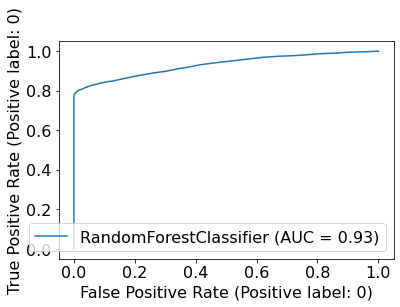

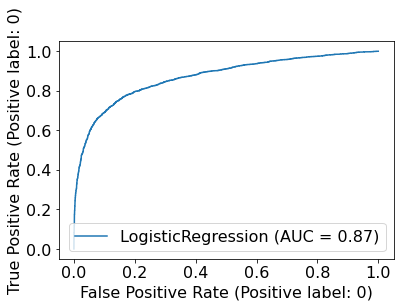

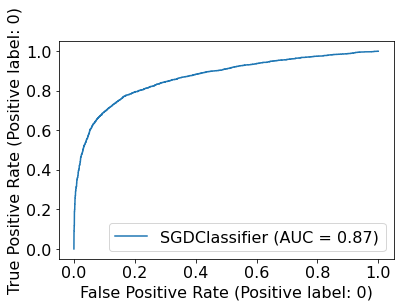

In [49]:
benchmarkAlgos(X_selected, y)

# Step 3.1: Random Forest Hyp-Tuning on selected features

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=42, stratify=y)
forest = RandomForestClassifier(random_state=10, verbose=0,n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
n_estimators = [100, 300, 500]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10, 100]
min_samples_leaf = [1, 2, 5, 10] 
bootstrap = [True, False]
hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap=bootstrap)
print(hyperF)
gridF = RandomizedSearchCV (forest, hyperF, cv = cv, verbose = 2, n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
y_pred = bestF.predict(X_test)

y_prob = bestF.predict_proba(X_test)[:, 1]

accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
print("-----------------------------------------------------------------------\n")


score = bestF.score(X_test, y_test)
print("score {:.3f}".format(score))



{'n_estimators': [100, 300, 500], 'max_depth': [5, 8, 15], 'min_samples_split': [2, 5, 10, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}
Fitting 15 folds for each of 10 candidates, totalling 150 fits
accuracy = 0.889 
precision = 0.910 
recall = 0.889 
f1 = 0.888 
AUC score = 0.934
-----------------------------------------------------------------------

score 0.889


In [ ]:
print("Best: %f using %s" % (gridF.best_score_, gridF.best_params_))
means = gridF.cv_results_['mean_test_score']
stds = gridF.cv_results_['std_test_score']
params = gridF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Step3.2: Logistic Regression Hyper tuning

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=42, stratify=y)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.786426 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.786370 (0.006126) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.786358 (0.006118) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786352 (0.006135) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.786370 (0.006126) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.786383 (0.006127) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786358 (0.006138) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.786346 (0.006136) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.786352 (0.006131) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786346 (0.006158) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.786426 (0.006207) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.786395 (0.006186) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786370 (0.006252) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.786080 (0.006057) wit

In [58]:
y_pred = grid_result.predict(X_test)

y_prob = grid_result.predict_proba(X_test)[:, 1]

accuracy, precision, recall, f1, auc = get_metrics(y_test, y_pred,y_prob)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \nAUC score = %.3f" % (accuracy, precision, recall, f1,auc))
print("-----------------------------------------------------------------------\n")


score = grid_result.score(X_test, y_test)
print("score {:.3f}".format(score))

accuracy = 0.795 
precision = 0.796 
recall = 0.795 
f1 = 0.795 
AUC score = 0.870
-----------------------------------------------------------------------

score 0.795


Automatically created module for IPython interactive environment


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   19.3s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   27.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   33.5s remaining:   57.9s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   46.0s remaining:   46.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   58.2s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.0min remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.2min remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


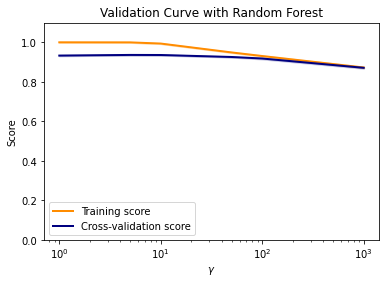

In [15]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

X=X_selected

param_range  = [1, 5, 10,50,100, 1000] 

train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X, y, param_name="min_samples_leaf", param_range=param_range,
    scoring="roc_auc", n_jobs=-1, verbose=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [11]:
RandomForestClassifier().get_params().keys()


dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

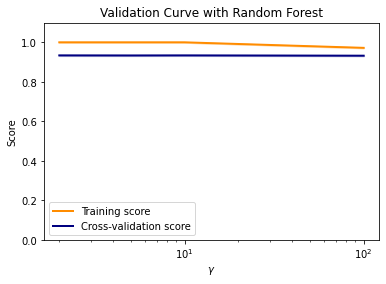

In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()